# EO-Forge Loaders 1.0.2

## EO-Forge Loaders

__NOTE__: EO-Forge Loaders are meant to be used on a "local" archiving scheme (your laptop storage, a NFS storage,etc) not (__yet__) on Cloud Buckets, but more on this latter!

We will cover the basics steps to load an scene (and crop some roi-_region of interest_- on it) of:

-  Sentinel 2 - processing level: __L2A__ (on-duty)

### Images

We assume that you have already downloaded some images (you could use _sentinelsat_ for instance).

We are insterested on Tile __19FCF__ (just to continue with the same images from previous examples).

You can download this with the sentinelsat library using:

```python
from sentinelsat import SentinelAPI
api = SentinelAPI('user', 'password', 'https://apihub.copernicus.eu/apihub')

# api.download(<product_id>)
api.download("eb2b9bc6-bbb4-4d89-bab7-f9508cb877d2")
```

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import rasterio as rio
import geopandas as gpd

from earthpy import plot

In [2]:
from eo_forge.io.SentinelLoaders import Sentinel2Loader

In [3]:
# Base dir
TMP_PROD = "./products-int/"
# IMAGES RAW Search Path
IMAGES_RAW = os.path.join(TMP_PROD, "images-raw")

# IMAGES CROP Path (to leave cropped files - if apply)
PROD_INT_DIR = os.path.join(TMP_PROD, "images-crop")
os.makedirs(PROD_INT_DIR, exist_ok=True)

## Sentinel2  Image

### No bbox

We will query and calibrate the whole image and we will return it as a file (not in memory).

__NOTE__: Image Raw _S2A_MSIL2A_20210810T141741_N0301_R010_T19FCF_20210810T200924.SAFE_ or with the same TILE should exist on IMAGES_RAW dir.

In [4]:
# Init Loader and query bands
SENTINEL2_BANDS = ["B02", "B03", "B04", "B08", "B11"]
lp = Sentinel2Loader(
    IMAGES_RAW, bands=SENTINEL2_BANDS, resolution=10, level="l2a"
)

2022/02/09 11:59:47 - INFO - Running on Sentinel 2 - l2a data


That is, we have instantiated the Loader with:
- folder: IMAGE_RAW, the place where we look for products (see later)
- bands: list of bands that we require to be processed
- resolution: pick 10 meters (default @ 20 meters)

And now call the processor for the requested product-id.

### Legacy Cloud Mask

We should set the kwarg:
- clouds_legacy to True

In [5]:
product_id = "S2A_MSIL2A_20210810T141741_N0301_R010_T19FCF_20210810T200924.SAFE"
res_ = lp.execute(
    product_id,
    bbox=None,
    folder_proc_=PROD_INT_DIR,
    raster_return_open=False,
    write_file="_complete",
    clouds_legacy=True
)

2022/02/09 11:59:48 - INFO - Processing on ./products-int/images-raw/S2A_MSIL2A_20210810T141741_N0301_R010_T19FCF_20210810T200924.SAFE dir
2022/02/09 11:59:48 - INFO - Using clipping flag: False
2022/02/09 11:59:48 - INFO - PROCESSING band: B02
2022/02/09 11:59:48 - INFO - resample: False - scale factor 1 - true pixel 10.0
2022/02/09 11:59:48 - INFO - no bbox - full match: True - area: 1
2022/02/09 11:59:57 - INFO - calibrating band
2022/02/09 11:59:58 - INFO - reprojecting band
2022/02/09 11:59:59 - INFO - PROCESSING band: B03
2022/02/09 11:59:59 - INFO - resample: False - scale factor 1 - true pixel 10.0
2022/02/09 11:59:59 - INFO - no bbox - full match: True - area: 1
2022/02/09 12:00:08 - INFO - calibrating band
2022/02/09 12:00:09 - INFO - reprojecting band
2022/02/09 12:00:10 - INFO - PROCESSING band: B04
2022/02/09 12:00:11 - INFO - resample: False - scale factor 1 - true pixel 10.0
2022/02/09 12:00:11 - INFO - no bbox - full match: True - area: 1
2022/02/09 12:00:19 - INFO - ca

In [6]:
# check res_
res_

{'raster': None,
 'raster_cloud': None,
 'match': 'TOTAL',
 'raster_path': './products-int/images-crop/S2A_MSIL2A_20210810T141741_N0301_R010_T19FCF_20210810T200924_complete.TIF',
 'raster_cloud_path': './products-int/images-crop/S2A_MSIL2A_20210810T141741_N0301_R010_T19FCF_20210810T200924_CLOUDS_complete.TIF'}

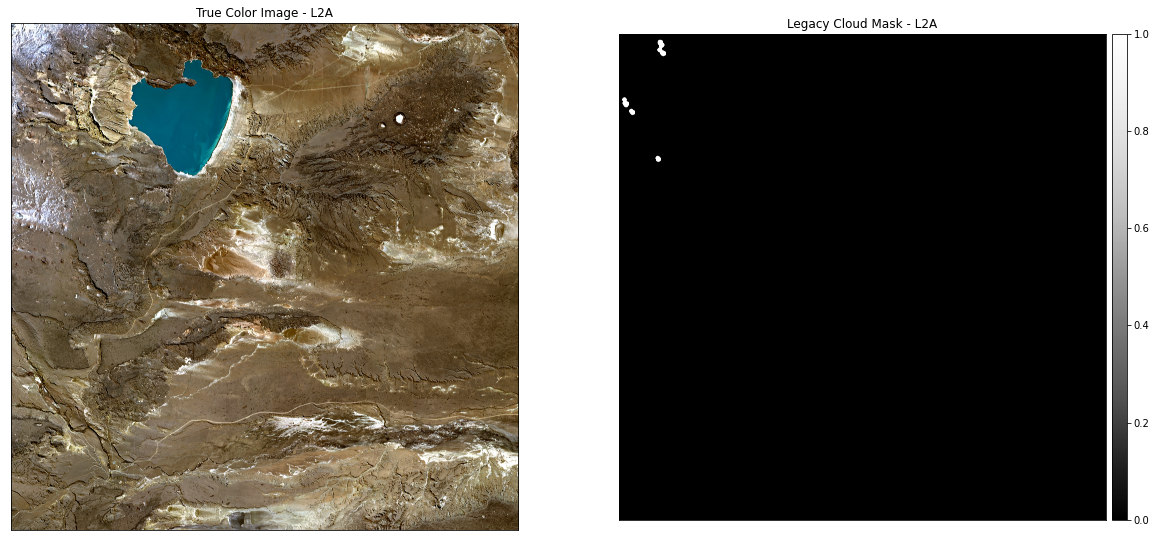

In [7]:
f, ax = plt.subplots(1, 2, figsize=(20, 20))
raster = rio.open(res_["raster_path"])
plot.plot_rgb(raster.read(), rgb=(2, 1, 0), ax=ax[0], stretch=True)
ax[0].set_title("True Color Image - L2A")
raster.close()

raster = rio.open(res_["raster_cloud_path"])
plot.plot_bands(raster.read(), ax=ax[1])
ax[1].set_title("Legacy Cloud Mask - L2A")
raster.close()

### SCL Cloud Mask

SCL keys:

- 0 	NO_DATA
- 1 	SATURATED_OR_DEFECTIVE
- 2 	DARK_AREA_PIXELS
- 3 	CLOUD_SHADOWS
- 4 	VEGETATION
- 5 	NOT_VEGETATED
- 6 	WATER
- 7 	UNCLASSIFIED
- 8 	CLOUD_MEDIUM_PROBABILITY
- 9 	CLOUD_HIGH_PROBABILITY
- 10 	THIN_CIRRUS
- 11 	SNOW

we filter by default with

`scl_filters: [1,2,3,4,5,6,7,8,10,11] `

You cold override this by setting this variable in execute method

In [8]:
product_id = "S2A_MSIL2A_20210810T141741_N0301_R010_T19FCF_20210810T200924.SAFE"
res_ = lp.execute(
    product_id,
    bbox=None,
    folder_proc_=PROD_INT_DIR,
    raster_return_open=False,
    write_file="_complete",
    clouds_legacy=False,
)

2022/02/09 12:02:25 - INFO - Processing on ./products-int/images-raw/S2A_MSIL2A_20210810T141741_N0301_R010_T19FCF_20210810T200924.SAFE dir
2022/02/09 12:02:25 - INFO - Using clipping flag: False
2022/02/09 12:02:25 - INFO - PROCESSING band: B02
2022/02/09 12:02:25 - INFO - resample: False - scale factor 1 - true pixel 10.0
2022/02/09 12:02:25 - INFO - no bbox - full match: True - area: 1
2022/02/09 12:02:33 - INFO - calibrating band
2022/02/09 12:02:34 - INFO - reprojecting band
2022/02/09 12:02:36 - INFO - PROCESSING band: B03
2022/02/09 12:02:36 - INFO - resample: False - scale factor 1 - true pixel 10.0
2022/02/09 12:02:36 - INFO - no bbox - full match: True - area: 1
2022/02/09 12:02:43 - INFO - calibrating band
2022/02/09 12:02:44 - INFO - reprojecting band
2022/02/09 12:02:45 - INFO - PROCESSING band: B04
2022/02/09 12:02:45 - INFO - resample: False - scale factor 1 - true pixel 10.0
2022/02/09 12:02:45 - INFO - no bbox - full match: True - area: 1
2022/02/09 12:02:51 - INFO - ca

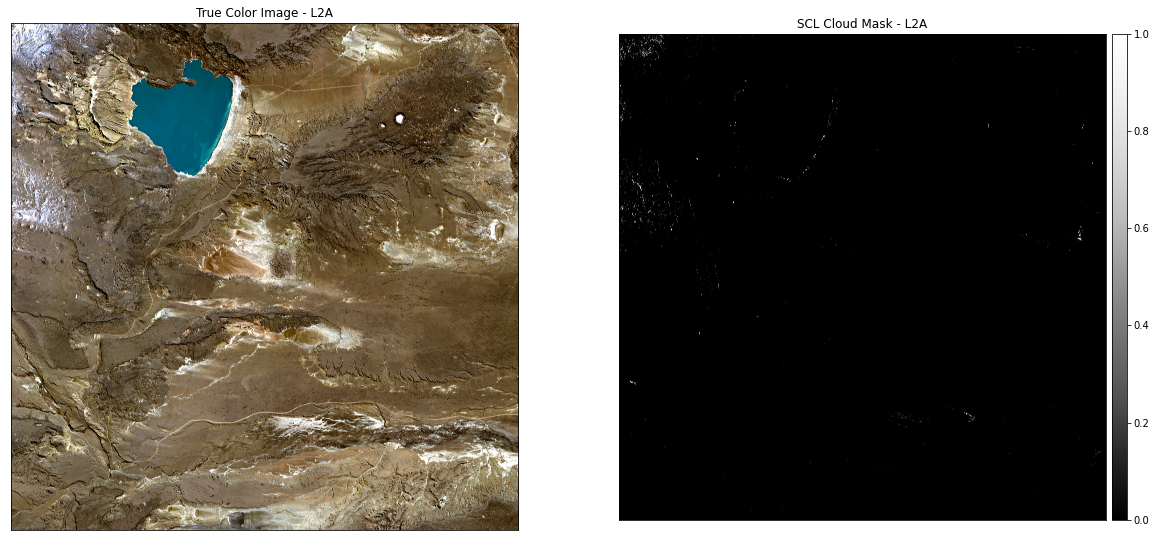

In [9]:
f, ax = plt.subplots(1, 2, figsize=(20, 20))
raster = rio.open(res_["raster_path"])
plot.plot_rgb(raster.read(), rgb=(2, 1, 0), ax=ax[0], stretch=True)
ax[0].set_title("True Color Image - L2A")
raster.close()

raster = rio.open(res_["raster_cloud_path"])
plot.plot_bands(raster.read(), ax=ax[1])
ax[1].set_title("SCL Cloud Mask - L2A")
raster.close()

Notice the difference between two cloud mask (both seems to be inaccurate) 

## BBox - Levels L2A and L1C

We compare the levels L2A and L1C from the same image (on a reduced BBox).

In [10]:
# now use bbox
bbox = gpd.read_file("./data/cardiel-lake.geojson")
# and do not write anything
product_id = "S2A_MSIL2A_20210810T141741_N0301_R010_T19FCF_20210810T200924.SAFE"

res_bbox = lp.execute(
    product_id,
    bbox=bbox,
    folder_proc_=PROD_INT_DIR,
    raster_return_open=True,
    write_file=None,
    clouds_legacy=True,
)

lp_l1c = Sentinel2Loader(
    IMAGES_RAW, bands=SENTINEL2_BANDS, resolution=10, level="l1c"
)
#
product_id_l1c = "S2A_MSIL1C_20210810T141741_N0301_R010_T19FCF_20210810T193059.SAFE"
res_bbox_l1c = lp_l1c.execute(
    product_id_l1c,
    bbox=bbox,
    folder_proc_=PROD_INT_DIR,
    raster_return_open=True,
    write_file=None,
    clouds_legacy=True,
)

2022/02/09 12:05:18 - INFO - Processing on ./products-int/images-raw/S2A_MSIL2A_20210810T141741_N0301_R010_T19FCF_20210810T200924.SAFE dir
2022/02/09 12:05:18 - INFO - Using clipping flag: True
2022/02/09 12:05:18 - INFO - PROCESSING band: B02
2022/02/09 12:05:18 - INFO - resample: False - scale factor 1 - true pixel 10.0
2022/02/09 12:05:19 - INFO - checking  ROI
2022/02/09 12:05:19 - INFO - checking roi match - full match: True - area: 1
2022/02/09 12:05:19 - INFO - clipping with Tight BBox
2022/02/09 12:05:19 - INFO - calibrating band
2022/02/09 12:05:19 - INFO - reprojecting band
2022/02/09 12:05:20 - INFO - PROCESSING band: B03
2022/02/09 12:05:20 - INFO - resample: False - scale factor 1 - true pixel 10.0
2022/02/09 12:05:20 - INFO - checking  ROI
2022/02/09 12:05:20 - INFO - checking roi match - full match: True - area: 1
2022/02/09 12:05:20 - INFO - clipping with Tight BBox
2022/02/09 12:05:20 - INFO - calibrating band
2022/02/09 12:05:21 - INFO - reprojecting band
2022/02/09 1

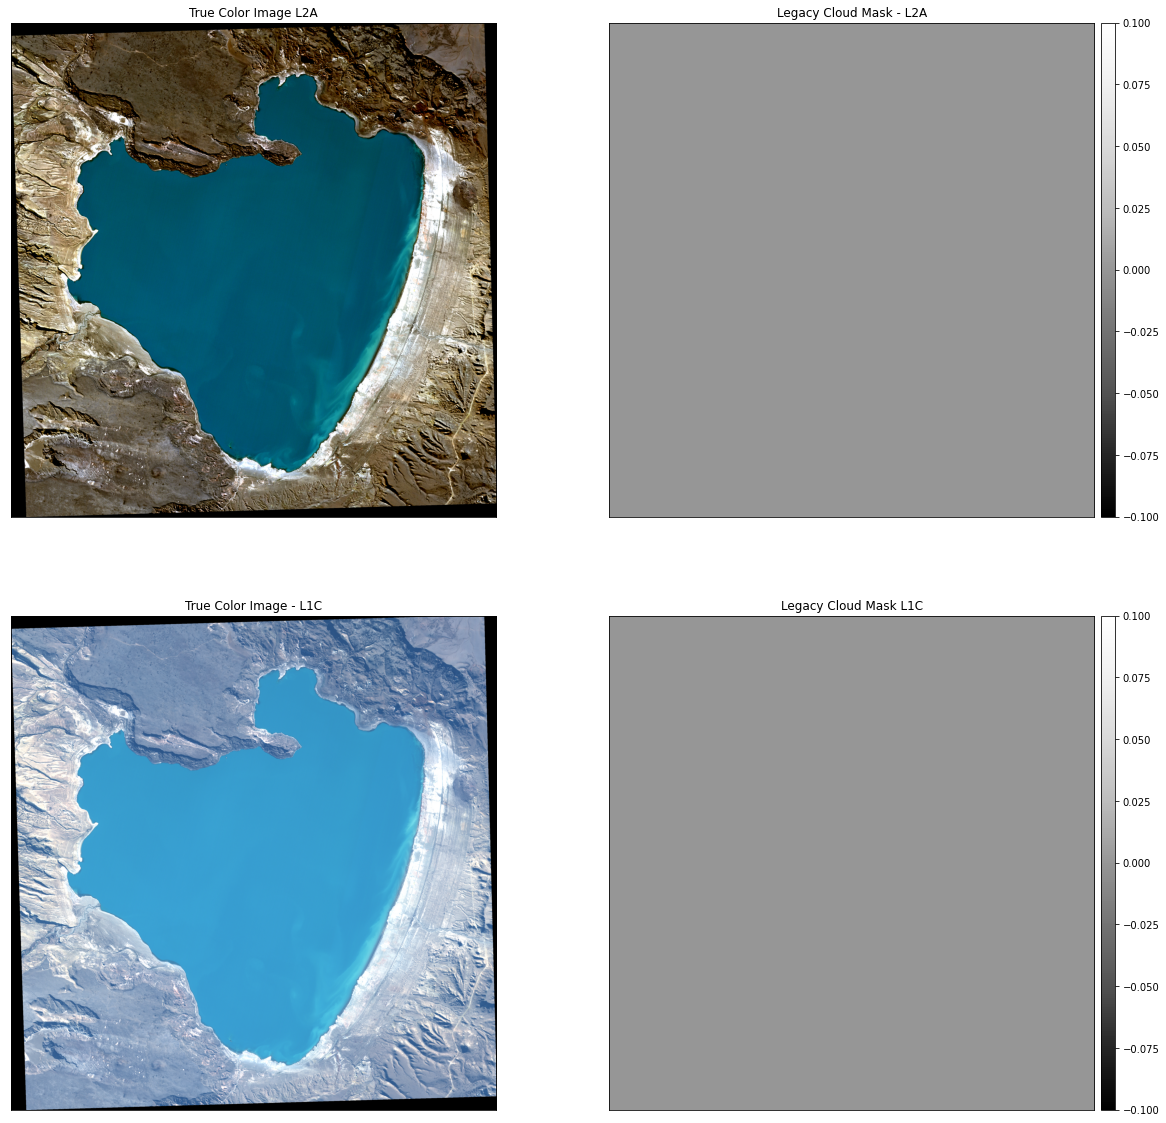

In [11]:
f, ax = plt.subplots(2, 2, figsize=(20, 20))
raster = res_bbox["raster"]
plot.plot_rgb(raster.read(), rgb=(2, 1, 0), ax=ax[0][0], stretch=True)
ax[0][0].set_title("True Color Image L2A")

raster = res_bbox["raster_cloud"]
plot.plot_bands(raster.read(), ax=ax[0][1])
ax[0][1].set_title("Legacy Cloud Mask - L2A")


raster = res_bbox_l1c["raster"]
plot.plot_rgb(raster.read(), rgb=(2, 1, 0), ax=ax[1][0], stretch=True)
ax[1][0].set_title("True Color Image - L1C")

raster = res_bbox_l1c["raster_cloud"]
plot.plot_bands(raster.read(), ax=ax[1][1])
ax[1][1].set_title("Legacy Cloud Mask L1C");

We now compute with the same BBox, but with SCL Mask (only for L2A level)

In [12]:
res_bbox = lp.execute(
    product_id,
    bbox=bbox,
    folder_proc_=PROD_INT_DIR,
    raster_return_open=True,
    write_file=None,
    clouds_legacy=False,
)

2022/02/09 12:05:50 - INFO - Processing on ./products-int/images-raw/S2A_MSIL2A_20210810T141741_N0301_R010_T19FCF_20210810T200924.SAFE dir
2022/02/09 12:05:50 - INFO - Using clipping flag: True
2022/02/09 12:05:50 - INFO - PROCESSING band: B02
2022/02/09 12:05:50 - INFO - resample: False - scale factor 1 - true pixel 10.0
2022/02/09 12:05:50 - INFO - checking  ROI
2022/02/09 12:05:50 - INFO - checking roi match - full match: True - area: 1
2022/02/09 12:05:50 - INFO - clipping with Tight BBox
2022/02/09 12:05:50 - INFO - calibrating band
2022/02/09 12:05:51 - INFO - reprojecting band
2022/02/09 12:05:51 - INFO - PROCESSING band: B03
2022/02/09 12:05:51 - INFO - resample: False - scale factor 1 - true pixel 10.0
2022/02/09 12:05:51 - INFO - checking  ROI
2022/02/09 12:05:51 - INFO - checking roi match - full match: True - area: 1
2022/02/09 12:05:51 - INFO - clipping with Tight BBox
2022/02/09 12:05:52 - INFO - calibrating band
2022/02/09 12:05:52 - INFO - reprojecting band
2022/02/09 1

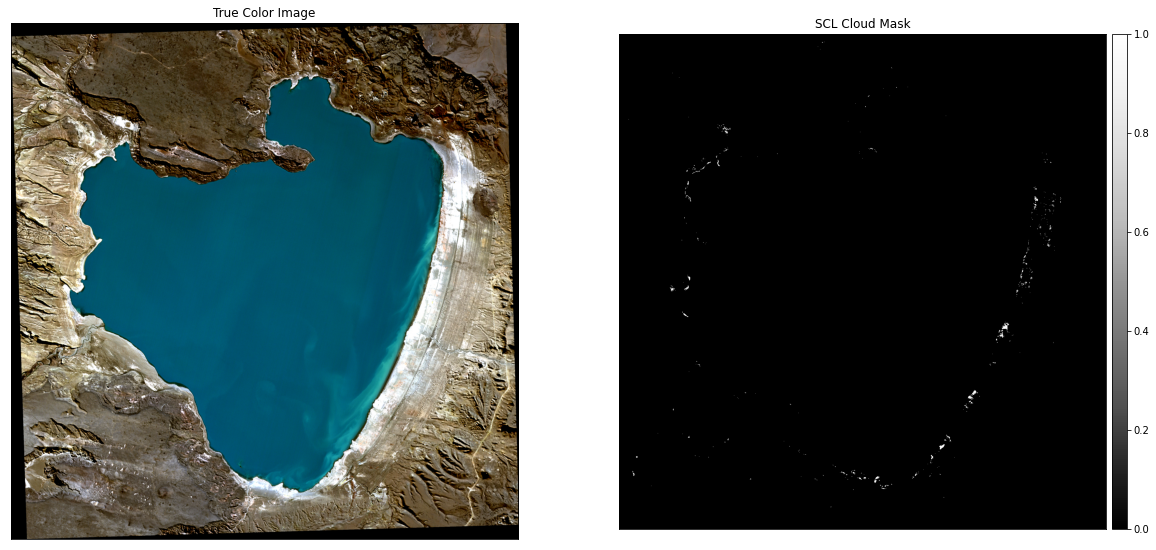

In [13]:
f, ax = plt.subplots(1, 2, figsize=(20, 20))
raster = res_bbox["raster"]
plot.plot_rgb(raster.read(), rgb=(2, 1, 0), ax=ax[0], stretch=True)
ax[0].set_title("True Color Image")

raster = res_bbox["raster_cloud"]
plot.plot_bands(raster.read(), ax=ax[1])
ax[1].set_title("SCL Cloud Mask");

## Partial Match

We try to force SCL on L1C (Check logs)

In [14]:
# now use bbox
bbox = gpd.read_file("./data/cardiel-lake-partial-S2.geojson")
# and do not write anything
product_id = "S2A_MSIL2A_20210810T141741_N0301_R010_T19FCF_20210810T200924.SAFE"

res_bbox = lp.execute(
    product_id,
    bbox=bbox,
    folder_proc_=PROD_INT_DIR,
    raster_return_open=True,
    write_file=None,
    clouds_legacy=False,
)

lp_l1c = Sentinel2Loader(
    IMAGES_RAW, bands=SENTINEL2_BANDS, resolution=10, level="l1c"
)

product_id_l1c = "S2A_MSIL1C_20210810T141741_N0301_R010_T19FCF_20210810T193059.SAFE"
res_bbox_l1c = lp_l1c.execute(
    product_id_l1c,
    bbox=bbox,
    folder_proc_=PROD_INT_DIR,
    raster_return_open=True,
    write_file=None,
    clouds_legacy=False,
)

2022/02/09 12:06:04 - INFO - Processing on ./products-int/images-raw/S2A_MSIL2A_20210810T141741_N0301_R010_T19FCF_20210810T200924.SAFE dir
2022/02/09 12:06:04 - INFO - Using clipping flag: True
2022/02/09 12:06:04 - INFO - PROCESSING band: B02
2022/02/09 12:06:04 - INFO - resample: False - scale factor 1 - true pixel 10.0
2022/02/09 12:06:04 - INFO - checking  ROI
2022/02/09 12:06:04 - INFO - checking roi match - full match: False - area: 0.7105503210242377
2022/02/09 12:06:04 - INFO - clipping with Tight BBox
2022/02/09 12:06:05 - INFO - reprojecting raster to BBox - Not Full Match Case
2022/02/09 12:06:05 - INFO - calibrating band
2022/02/09 12:06:06 - INFO - reprojecting band
2022/02/09 12:06:06 - INFO - PROCESSING band: B03
2022/02/09 12:06:06 - INFO - resample: False - scale factor 1 - true pixel 10.0
2022/02/09 12:06:06 - INFO - checking  ROI
2022/02/09 12:06:06 - INFO - checking roi match - full match: False - area: 0.7105503210242377
2022/02/09 12:06:06 - INFO - clipping with T

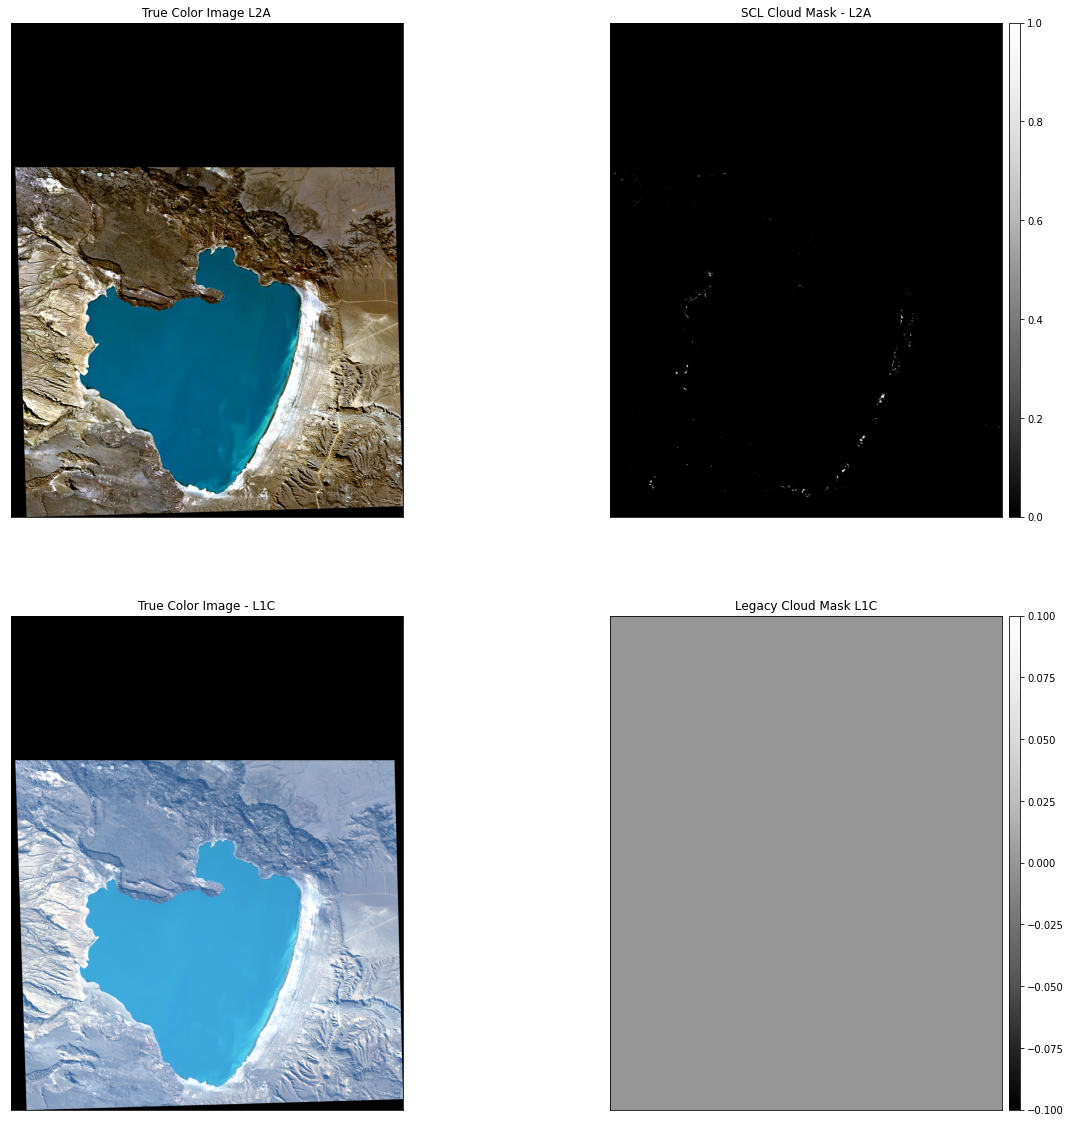

In [15]:
f, ax = plt.subplots(2, 2, figsize=(20, 20))
raster = res_bbox["raster"]
plot.plot_rgb(raster.read(), rgb=(2, 1, 0), ax=ax[0][0], stretch=True)
ax[0][0].set_title("True Color Image L2A")

raster = res_bbox["raster_cloud"]
plot.plot_bands(raster.read(), ax=ax[0][1])
ax[0][1].set_title("SCL Cloud Mask - L2A")


raster = res_bbox_l1c["raster"]
plot.plot_rgb(raster.read(), rgb=(2, 1, 0), ax=ax[1][0], stretch=True)
ax[1][0].set_title("True Color Image - L1C")

raster = res_bbox_l1c["raster_cloud"]
plot.plot_bands(raster.read(), ax=ax[1][1])
ax[1][1].set_title("Legacy Cloud Mask L1C");

Check the logs and notice the difference between areas in SCL and Legacy BQA processing. This is happens because SCL is already in raster format (so its area mismatch resembles to those of bands, and requires BBox reprojection to). However in legacy format (gml), the shapefile is processed and a raster is built based on this shape and an already reprojected raster  to the corresponding BBox (so in this case area mismatch is ~ 0).